<a href="https://colab.research.google.com/github/luke-scot/s4-thermal/blob/main/summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary of all techniques for stitching thermal drone imagery

This notebook summarises the techniques for stitching together drone images, with the intention to downsample them to a resolution for satellite imagery available from [S4](https://www.super-sharp.com/)'s future satellites.

You can run the following demo by clicking shift+enter on each cell.

## 1 - Data import
Images can either be imported directly in RGB or more helpfully pre-converted to thermal imagery. If you have thermal images in RGB, see the [s4-thermal](https://github.com/luke-scot/s4-thermal) Github repository for instructions to convert using [flirimageextractor](https://pypi.org/project/flirimageextractor/).

In [ ]:
! git clone https://github.com/luke-scot/s4-thermal.git
%cd s4-thermal/
! bash download_data.sh
# Double click next to the question to respond to prompt

In [18]:
# Variable definition
imgDir = 'data/lsm/lsm/Flight 1 - Library/thermal-data/' # Directory to images
imageType, cmap = False, 'hot' # True if RGB images, False if numpy arrays. Choose matplotlib cmap for thermal
pathFile = 'data/lsm/lsm/Flight 1.csv' # Flight path .csv file
utcDiff = -1 # Time difference to UTC (-1 for BST)
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)'] # Columns used from the path file
minAlt, maxAlt, altCol = 119.7, 120.3, 'altitude(m)' # Altitude criteria for using imagery, if wanted else False
imgTimes = [1619811011923,1619811099149] # Specify times if wanted else False
utmZone, hemisphere = '31n', 'north' # Specify UTM coordinate zone
pxSize = 0.27 # Specify pixel size (m) - for now

In [9]:
# Import necessary packages
%pip install imutils opencv-python rasterio pyproj
import os
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
import cv2
import imageio
import imutils
import helper_functions as hf
cv2.ocl.setUseOpenCL(False)

     |████████████████████████████████| 6.6MB 6.3MB/s 


Now we'll import the image and flight path data into usable dataframes

In [19]:
## Get image dataframe with corresponding properties extracted frpm path file
fileTypes = ('.jpg','.png','.tif') if imageType else ('.npy')
imgs = [_ for _ in glob.glob(imgDir+'*.*') if _.endswith(fileTypes)]
imgs.sort()
# Extract date and time from filenames
imgdates = [re.search('/20(.+?)_', path).group(1) for path in imgs] # Extract date from filename
imgtimes = [re.search('_(.+?)_', path).group(1) for path in imgs] # Extract time from filename
# Convert to unix datetime 
imgdatetimes = np.array([(datetime.timestamp(datetime(int('20'+imgdates[i][:2]),int(imgdates[i][2:4]),int(imgdates[i][4:6]),int(imgtimes[i][:2])+utcDiff,int(imgtimes[i][2:4]),int(imgtimes[i][4:6])))) for i in range(len(imgs))])*1000

# Imprt paths and get corresponding timestamps for images
pathDf = pd.read_csv(pathFile)
# Get nearest GPS timestamp
gpstimes = [min(pathDf['timestamp'], key=(lambda list_value : abs(list_value - i))) for i in imgdatetimes]

# Create image dataframe
imgDf = pd.DataFrame(data=np.array([imgs,gpstimes]).transpose(),columns=['imgPath','timestamp'])
imgDf['timestamp'] = imgDf['timestamp'].astype(float)

# Merge with path dataframe
merged = imgDf.merge(pathDf[pathColumns], on='timestamp', how='left')
# Filter for acceptable measurement altitudes
merged = merged.loc[(merged[altCol] > minAlt) & (merged[altCol] < maxAlt)]
if imgTimes: merged = merged.loc[(merged['timestamp'] > imgTimes[0]) & (merged['timestamp'] < imgTimes[1])]

# Convert coordinates to UTM
myProj = Proj('+proj=utm +zone='+utmZone+' +'+hemisphere+' +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
merged['x'], merged['y'] = myProj(merged['longitude'].values, merged['latitude'].values)

# Display example
merged.head()

CRSError: ignored

In [20]:
utmZone

'31n'

## 2 - Visualise example data

Let's visualise an example of the imagery we have chosen and the path of the drone during this capture. You can adjust the parameters at the top of the cell if you fancy.

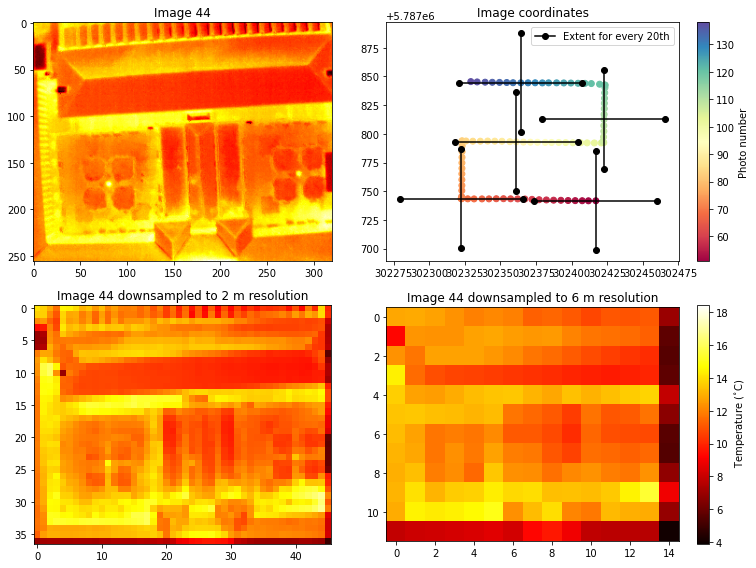

In [ ]:
## Plot flight path with an example image and downscale
useCentre = True # True if only using center of images
imageNum = 44 # Example image
resolutions = [2, 6, 60] # Resolutions to downsample to 
skip = 20 # Plot every nth image for path

# Plot example image
fig, axs = plt.subplots(2,2,figsize=[11,8])
arr = hf.img_to_arr(merged.iloc[imageNum]['imgPath'])
yCoords, xCoords = [(np.array(range(arr.shape[i]))-(arr.shape[i]/2))*pxSize+pxSize/2 for i in [0,1]]
if useCentre: xq, yq = int(np.floor(len(xCoords)/4)), int(np.floor(len(yCoords)/4))
else: xq, yq = False, False
arr = hf.img_to_arr(merged.iloc[imageNum]['imgPath'], xq=xq, yq=yq)
a = axs[0,0].imshow(arr, cmap=cmap)
axs[0,0].set_title('Image {}'.format(imageNum))

# Plot route
b = axs[0,1].scatter(merged.x,merged.y,c=merged.index, cmap='Spectral')
size = np.array(arr.shape[:2])*pxSize/2
for i, row in merged[::skip].iterrows():
    axs[0,1].plot([row.x-size[1], row.x+size[1]], [row.y, row.y],'k-o')
    axs[0,1].plot([row.x, row.x],[row.y-size[1], row.y+size[1]],'k-o')
axs[0,1].set_title('Image coordinates')
axs[0,1].legend(labels=['Extent for every {}th'.format(skip)])
fig.colorbar(b, ax=axs[0,1],label='Photo number')

# Plot example downsampled image
for i, val in enumerate(resolutions):
    ds_array = hf.downsample_arr(arr, pxSize, val)
    if i<2:
        c = axs[1,i].imshow(ds_array) if imageType else axs[1,i].imshow(ds_array, vmin=arr.min(), vmax=arr.max(),cmap=cmap)
        axs[1,i].set_title('Image {} downsampled to {} m resolution'.format(str(imageNum),val))
if imageType is False: fig.colorbar(c, ax=axs[1,1], label=' Temperature ($^{\circ}$C)')
fig.tight_layout()
plt.show()

In [ ]:
# Save figure if you would like
#fig.savefig('plots/Image{}.png'.format(str(imageNum)))

## 3 - Combine images based on coordinates

### Coordinate correction
Let's first have a look at the coordinate path, to assess reliability.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


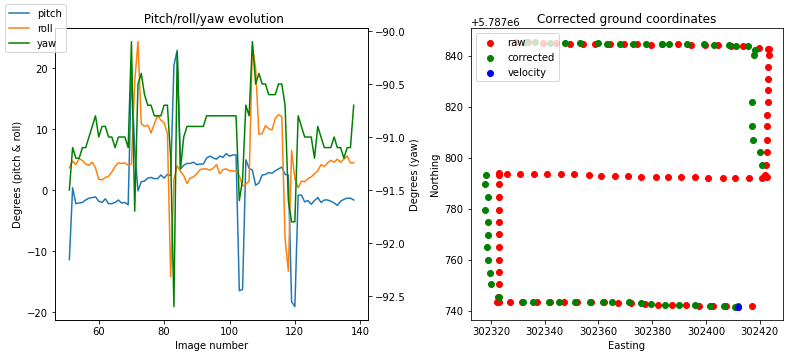

In [ ]:
distFilt = 6 # Filter out images where angle is high

fig, (ax, ax2) = plt.subplots(1,2,figsize=[11,5])
# Pitch/roll/yaw plot
ax.plot(merged.index,merged['pitch(deg)'],label='pitch')
ax.plot(merged.index,merged['roll(deg)'],label='roll')
par1 = ax.twinx()
par1.plot(merged.index,merged['yaw(deg)'],c='g',label='yaw')
ax.set_title(' Pitch/roll/yaw evolution')
ax.set_xlabel('Image number'), ax.set_ylabel('Degrees (pitch & roll)')
par1.set_ylabel('Degrees (yaw)')
fig.legend(loc='upper left')

# Coordinate corrections
# Raw
ax2.scatter(merged.x,merged.y,c='r',label='raw')
# Angle corrected
dist = merged['altitude(m)']*np.tan(np.deg2rad(merged['pitch(deg)']))
merged['xc'], merged['yc'] = merged.x+(dist*np.sin(np.deg2rad(merged['yaw(deg)']))), merged.y+(dist*np.cos(np.deg2rad(merged['yaw(deg)'])))
if distFilt: idf = merged[abs(dist) < distFilt]
else: idf = merged.copy()
ax2.scatter(idf['xc'],idf['yc'],c='g',label='corrected')
# Using velocity
xyvs = np.zeros([len(idf), 2])
xyvs[0,:] = idf.iloc[0][['x','y']]
for num, i in enumerate(idf.index[1:]):
    # Coordinates from initial and speed
    vels = pathDf.loc[pathDf.loc[pathDf['timestamp']==idf.iloc[num-1]['timestamp']].index[0]:pathDf.loc[pathDf['timestamp']==idf.iloc[num]['timestamp']].index[0]][['velocityX(mps)','velocityY(mps)','yaw(deg)']].mean()
    a = np.arctan(vels[1]/vels[0])
    v = np.hypot(vels[0],vels[1])#vels[1]/np.cos(a)# if np.cos(a) != 0 else vels[0]/np.sin(-a)
    #print(a)
    x = v*np.cos(np.deg2rad(90)-(np.deg2rad(vels[2])+a))
    y = v*np.sin(np.deg2rad(90)-(np.deg2rad(vels[2])+a))
    #if x == 0: print(i)
    xyvs[num+1,:] = [xyvs[num,0]-y, xyvs[num,1]-x]
ax2.scatter(xyvs[:,0],xyvs[:,1],c='b',label='velocity')    
ax2.legend()
ax2.set_title('Corrected ground coordinates')
ax2.set_xlabel('Easting'), ax2.set_ylabel('Northing')

fig.tight_layout()

In [ ]:
# Save figure if you would like
#fig.savefig('plots/Image{}.png'.format(str(imageNum)))

### Plot merged image

Ok now let's see the result of taking the nearest values over a grid of the whole area

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
54it [00:02, 20.49it/s]


Text(0.5, 1.0, 'Interpolation to grid using every 1 images')

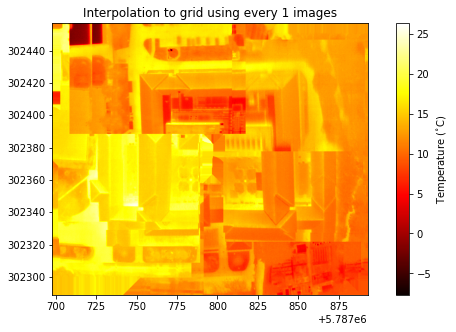

In [ ]:
# Loop over resolution to create combined image for each
# Initial setup
resolution = pxSize # Target resolution
skip = 1 # Use every nth image
coords = ['xc','yc'] # Use this set of coordinates (x: raw, xc: corrected, xv: velocity, xvc: velocity+corrected)
xmCoords, ymCoords = np.meshgrid(xCoords[xq:3*xq],yCoords[yq:3*yq]) if useCentre else np.meshgrid(xCoords,yCoords)
xmcr, ymcr = xmCoords.reshape(-1,1), ymCoords.reshape(-1,1)

# Loop over images
idf['y'], idf['x'] = myProj(idf['longitude'].values, idf['latitude'].values)
idf['xc'], idf['yc'] = idf.x+(dist*np.sin(np.deg2rad(idf['yaw(deg)']))), idf.y+(dist*np.cos(np.deg2rad(idf['yaw(deg)'])))

alltot = [0,0,0,0,0] if imageType else [0,0,0]
for index, row in tqdm(idf[::skip].iterrows()):
    imgst = hf.img_to_arr(row.imgPath, xq, yq)
    total = np.concatenate((xmcr+row[coords[0]], ymcr+row[coords[1]], imgst.reshape(-1,1) if len(imgst.shape) == 2 else [imgst[:,:,i].reshape(-1,1) for i in range(len(imgst.shape))]),axis=-1)
    alltot = np.vstack((alltot,total))

alltot = alltot[1:,:]
extot = (np.ceil(min(alltot[:,0])), np.floor(max(alltot[:,0])),np.ceil(min(alltot[:,1])),np.floor(max(alltot[:,1])))# minx, maxx, miny, maxy = min(total[:,0]), max(total[:,0]), min(total[:,1]), max(total[:,1])

xsGrid = np.arange(extot[0], extot[1], resolution)
ysGrid = np.arange(extot[2], extot[3], resolution)
xsGridm, ysGridm = np.meshgrid(xsGrid, ysGrid)

method = 'nearest'
gridded = [griddata(alltot[1:,:2], alltot[1:,i], (xsGridm, ysGridm), method=method) for i in range(alltot.shape[1])[2:]]
plt_grid = gridded[0] if alltot.shape[1] == 3 else np.dstack(([gridded[i] for i in range(alltot.shape[1]-2)]))

# Plot 
fig, ax = plt.subplots(1,1,figsize=[10,5])
if alltot.shape[1] == 3:
    a = ax.imshow(plt_grid,extent=extot,cmap=cmap)  
    c = fig.colorbar(a, ax=ax)
    c.set_label('Temperature ($^{\circ}$C)')

else: ax.imshow(plt_grid,extent=extot)
ax.set_title('Interpolation to grid using every '+str(skip)+' images')

### Downsample

(Text(0.5, 1.0, 'Full resolution'), Text(0.5, 1.0, '6 m resolution'))

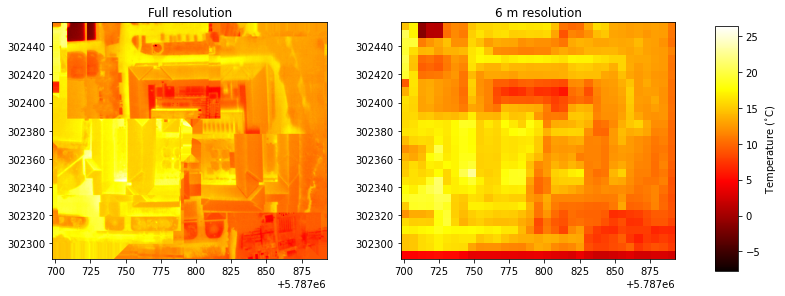

In [ ]:
resolution = 6 # Target resolution

# Plot 
fig, axs = plt.subplots(1,2,figsize=[11,4])
a = axs[0].imshow(plt_grid,extent=extot, cmap=cmap)
b = axs[1].imshow(hf.downsample_arr(plt_grid,pxSize,resolution),extent=extot, cmap=cmap, vmin=plt_grid.min(),vmax=plt_grid.max())
fig.tight_layout(h_pad=1)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.03, 0.85])
c = fig.colorbar(a, cax=cbar_ax)
c.set_label('Temperature ($^{\circ}$C)')
axs[0].set_title('Full resolution'), axs[1].set_title(str(resolution)+' m resolution')

In [ ]:
# Save figure if you would like
fig.savefig('plots/filteredThermal.png',bbox_inches='tight')

## 4 - OpenCV image stitching 
If coordinates are too inaccurate for a reliable image and the corrections are still not good enough. Then let's try image stitching.

### 2-image example

Lossy conversion from float64 to uint8. Range [10.389745479535748, 25.90414782143756]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.413839520192312, 26.239408521021744]. Convert image to uint8 prior to saving to suppress this warning.


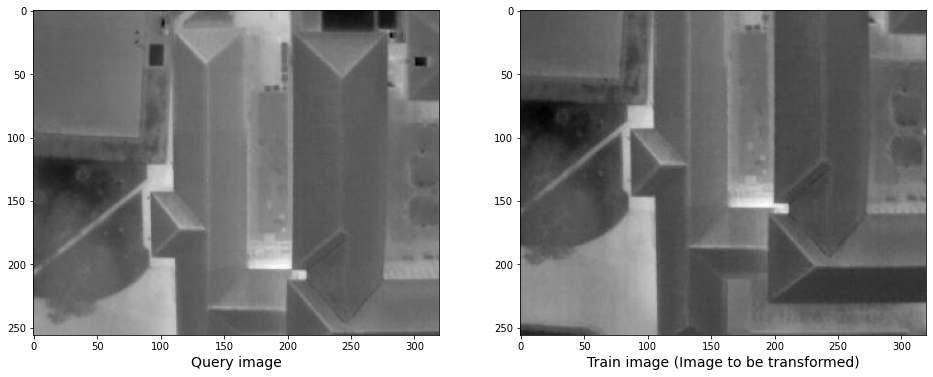

In [ ]:
## Visualise images to be stitched
imageNums = [5,7]

# Stitching properties
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'
arrs = [hf.img_to_arr(merged.iloc[imageNums[0]]['imgPath'], xq=xq, yq=yq),hf.img_to_arr(merged.iloc[imageNums[1]]['imgPath'], xq=xq, yq=yq)]
tempfiles = ['temp0.jpg','temp1.jpg']
for i, val in enumerate(tempfiles): imageio.imwrite(val,np.dstack((arrs[i],arrs[i],arrs[i])))
# Read images - Make sure that the train image is the image that will be transformed
trainImg, queryImg = [imageio.imread(i) for i in ['temp0.jpg','temp1.jpg']]
#for i in tempfiles: os.remove(i)
# Opencv defines the color channel in the order BGR - transform it to RGB to be compatible to matplotlib
trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap=cmap), ax1.set_xlabel("Query image", fontsize=14)
ax2.imshow(trainImg, cmap=cmap), ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)
plt.show()

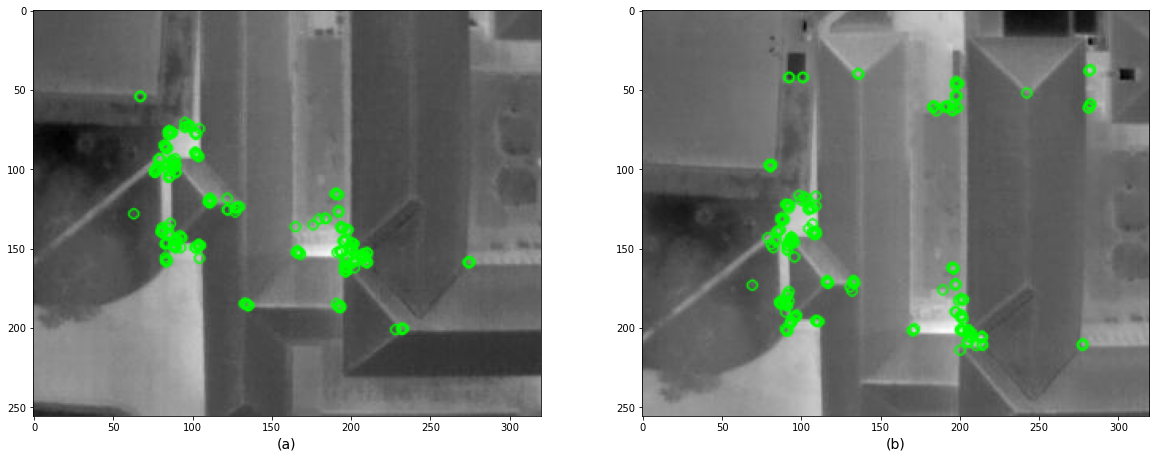

In [ ]:
# Detect the keypoints and features on both images
kpsA, featuresA = hf.detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = hf.detectAndDescribe(queryImg_gray, method=feature_extractor)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

Using: bf feature matcher
Raw matches (Brute force): 88


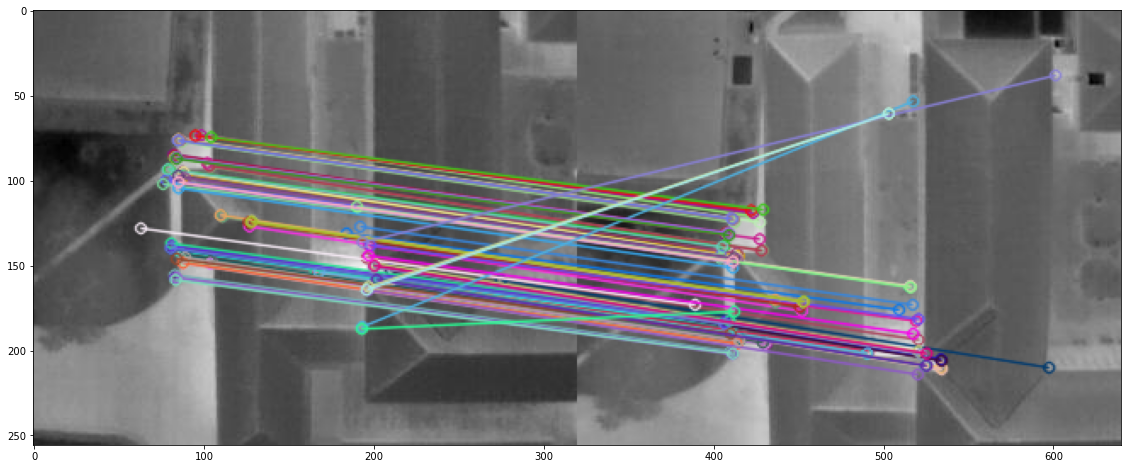

In [ ]:
# Link  the identified features between images
feature_extractor = 'brisk'
feature_matching = 'bf'
print("Using: {} feature matcher".format(feature_matching))
fig = plt.figure(figsize=(20,8))
if feature_matching == 'bf':
    matches = hf.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = hf.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

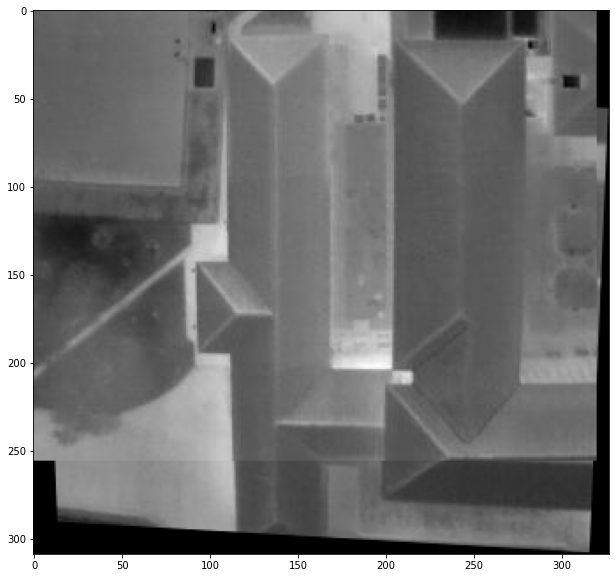

In [ ]:
# Combine the images according to the identified matches
M = hf.getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error, no matches!")
(matches, H, status) = M

# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

In [ ]:
# Save figure
# image_to_write = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
# cv2.imwrite("plots/thermalStitch.png", image_to_write)

### Multi-image stitching
Ok so over 2 images stitching seems to work alright, what happens if we recursively try stitching images together. Specify the start and images at the top of the cell as well as the number skipped. I recommend not skipping too many if you are only using the centre of the images.

Lossy conversion from float64 to uint8. Range [9.599275595896756, 24.438775488748604]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 0/10 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [9.599275595896756, 24.438775488748604]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [10.17962305200058, 24.89186321956049]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.62573554592558, 24.937063273359115]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.810739656503927, 25.36548634653917]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [10.127016773253104, 25.545349065194273]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████     | 5/10 [00:00<00:00, 49.73it/s]Lossy 

Raw matches (Brute force): 124
Raw matches (Brute force): 76
Raw matches (Brute force): 72
Raw matches (Brute force): 81
Raw matches (Brute force): 95
Raw matches (Brute force): 126
Raw matches (Brute force): 113
Raw matches (Brute force): 107
Raw matches (Brute force): 106
Raw matches (Brute force): 131


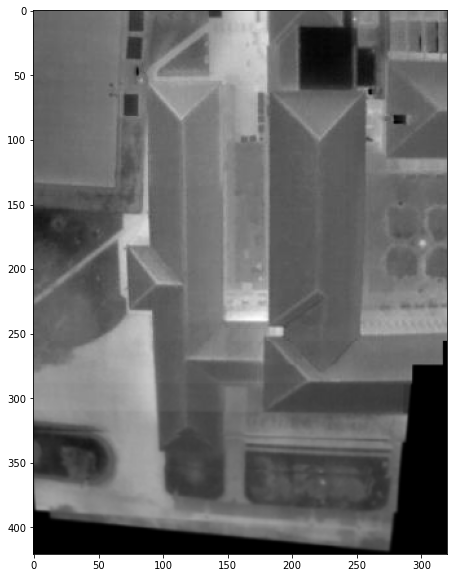

In [ ]:
# Stitching properties
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'
min_matches = 50
start = 0
end = 10
tempfiles = ['temp0.jpg','temp1.jpg']

arr = hf.img_to_arr(merged.iloc[start]['imgPath'], xq=xq, yq=yq)
imageio.imwrite(tempfiles[0],np.dstack((arr,arr,arr)))
result = imageio.imread(tempfiles[0])
for i in tqdm(np.arange(start,end,1 if start < end else -1)):
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
    arr = hf.img_to_arr(merged.iloc[i]['imgPath'], xq=xq, yq=yq)
    imageio.imwrite(tempfiles[1],np.dstack((arr,arr,arr)))
    # Read images - Make sure that the train image is the image that will be transformed
    trainImg, queryImg = result, imageio.imread('temp1.jpg')
    
    # Opencv defines the color channel in the order BGR - transform it to RGB to be compatible to matplotlib
    trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]

    kpsA, featuresA = hf.detectAndDescribe(trainImg_gray, method=feature_extractor)
    kpsB, featuresB = hf.detectAndDescribe(queryImg_gray, method=feature_extractor)
    
    if feature_matching == 'bf':
        matches = hf.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)

    elif feature_matching == 'knn':
        matches = hf.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)

    M = hf.getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
    if M is None: print("Error, no matches!")
    (matches, H, status) = M
    
    if len(matches) > min_matches:
        # Apply panorama correction
        width = trainImg.shape[1] + queryImg.shape[1]
        height = trainImg.shape[0] + queryImg.shape[0]

        warp = cv2.warpPerspective(trainImg, H, (width, height))
        if warp.shape[0] <= height and warp.shape[1] <= width: 
            result = warp.copy()
        #result[-queryImg.shape[0]:, -queryImg.shape[1]:] = queryImg
            result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg
            # transform the panorama image to grayscale and threshold it 
            gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
            thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

            # Finds contours from the binary image
            cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)

            # get the maximum contour area
            c = max(cnts, key=cv2.contourArea)

            # get a bbox from the contour area
            (x, y, w, h) = cv2.boundingRect(c)

            # crop the image to the bbox coordinates
            result = result[y:y + h, x:x + w]

# show the cropped image
for i in tempfiles: os.remove(i)
image_to_write = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
comboImg = "plots/combo.jpg"
cv2.imwrite(comboImg, image_to_write)
plt.figure(figsize=(20,10))
plt.imshow(result)

In [ ]:
# Save figure
image_to_write = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite("plots/thermalStitch1.png", image_to_write)

True

## 5 - Merge on key points (no perspective shift)
At this point I think the best bet may be a combination of the approaches. Therefore if we use RANSAC to identify key points. And then overlay images according to the key points to create a map, instead of warping perspective for a panorama like OpenCV tools.

### 2 image demonstration

Lossy conversion from float64 to uint8. Range [9.360788028050763, 25.04997741634304]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [10.258475639523397, 25.56781011830566]. Convert image to uint8 prior to saving to suppress this warning.


Raw matches (Brute force): 209
Using: bf feature matcher
Raw matches (Brute force): 209


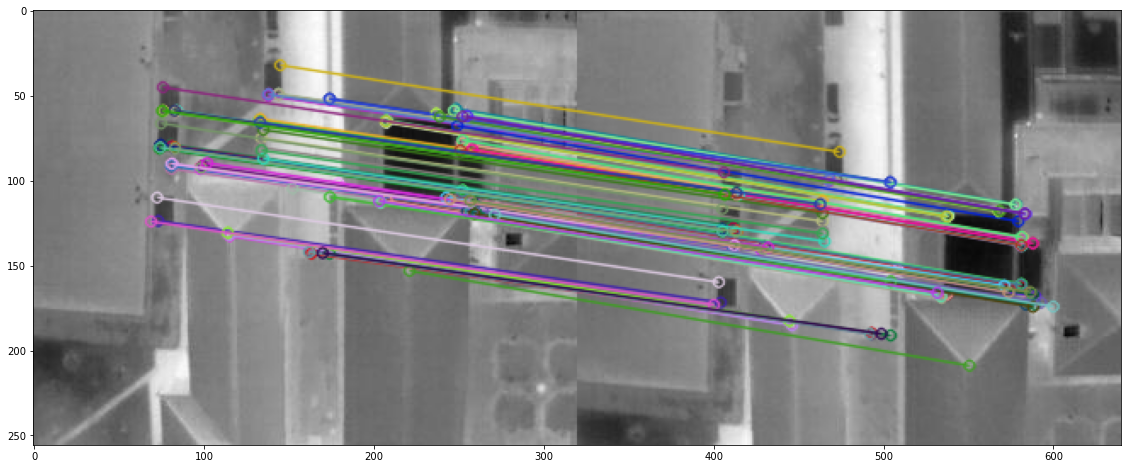

In [ ]:
## Visualise images to be stitched
imageNums = [10,12]

# Stitching properties
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'
arrs = [hf.img_to_arr(idf.iloc[imageNums[0]]['imgPath'], xq=xq, yq=yq),hf.img_to_arr(idf.iloc[imageNums[1]]['imgPath'], xq=xq, yq=yq)]
tempfiles = ['temp0.jpg','temp1.jpg']
for i, val in enumerate(tempfiles): imageio.imwrite(val,np.dstack((arrs[i],arrs[i],arrs[i])))
# Read images - Make sure that the train image is the image that will be transformed
trainImg, queryImg = [imageio.imread(i) for i in ['temp0.jpg','temp1.jpg']]
#for i in tempfiles: os.remove(i)
# Opencv defines the color channel in the order BGR - transform it to RGB to be compatible to matplotlib
trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]

# Detect the keypoints and features on both images
kpsA, featuresA = hf.detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = hf.detectAndDescribe(queryImg_gray, method=feature_extractor)

if feature_matching == 'bf':
    matches = hf.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)

elif feature_matching == 'knn':
    matches = hf.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)

# Link  the identified features between images
feature_extractor = 'brisk'
feature_matching = 'bf'
print("Using: {} feature matcher".format(feature_matching))
fig = plt.figure(figsize=(20,8))
if feature_matching == 'bf':
    matches = hf.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = hf.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

(Text(0.5, 1.0, 'Original: 209 points'),
 Text(0.5, 1.0, 'Filtered for direction: 203 points'))

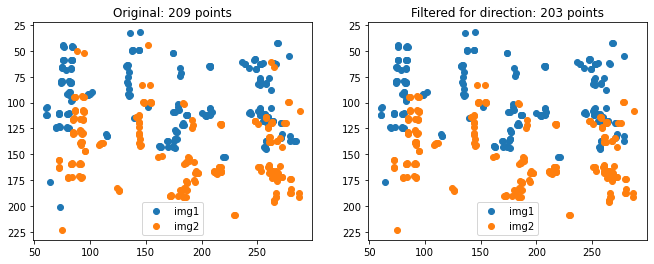

In [ ]:
# Potential to improve by filtering out matches that are not in same direction of travel as drone
ma = np.array([kpsA[j].pt for j in [i.queryIdx for i in matches]])
mb = np.array([kpsB[j].pt for j in [i.trainIdx for i in matches]])

# Filter by only matches in direction of travel
xmov, ymov = idf.iloc[imageNums[1]]['xc']-idf.iloc[imageNums[0]]['xc'], idf.iloc[imageNums[1]]['yc']-idf.iloc[imageNums[0]]['yc']
bothMov = 2
if xmov < bothMov/2 and ymov < bothMov/2:
    mam, mbm = ma, mb
else: 
    if abs(xmov) > abs(ymov):
        if xmov < 0:
            mam, mbm = ma[[ma[i,0]<mb[i,0] for i in range(len(ma))]], mb[[ma[i,0]<mb[i,0] for i in range(len(ma))]]
        else: mam, mbm = ma[[ma[i,0]>mb[i,0] for i in range(len(ma))]], mb[[ma[i,0]>mb[i,0] for i in range(len(ma))]]
    else:
        if ymov < 0:
            mam, mbm = ma[[ma[i,1]<mb[i,1] for i in range(len(ma))]], mb[[ma[i,1]<mb[i,1] for i in range(len(ma))]]
        else: mam, mbm = ma[[ma[i,1]>mb[i,1] for i in range(len(ma))]], mb[[ma[i,1]>mb[i,1] for i in range(len(ma))]]
            
fig, axs = plt.subplots(1,2,figsize=[11,4])
axs[0].scatter(ma[:,0],ma[:,1],label='img1')
axs[0].scatter(mb[:,0],mb[:,1],label='img2')
axs[0].invert_yaxis()
axs[0].legend()
axs[1].scatter(mam[:,0],mam[:,1],label='img1')
axs[1].scatter(mbm[:,0],mbm[:,1],label='img2')
axs[1].legend()
axs[1].invert_yaxis()
axs[0].set_title('Original: {} points'.format(str(len(ma)))), axs[1].set_title('Filtered for direction: {} points'.format(str(len(mam))))
    

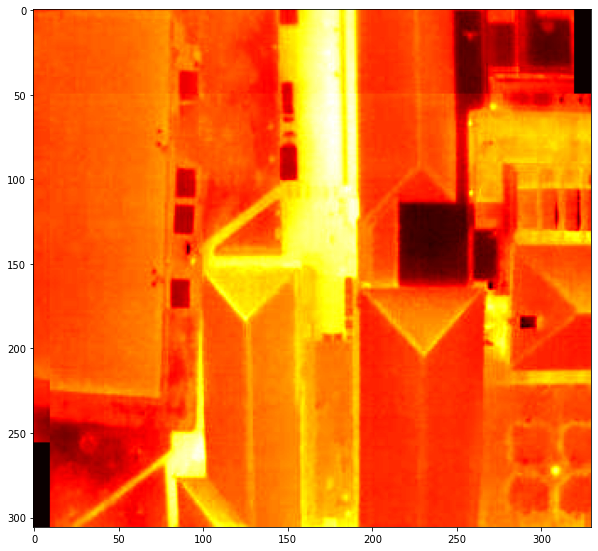

In [ ]:
diff = np.round(np.median(mam-mbm, axis=0)).astype(int)
if len(mam) > 10 and np.std(mam-mbm, axis=0).mean() < 5:
    result = np.zeros([trainImg.shape[0]+abs(diff[1]),trainImg.shape[1]+abs(diff[0]),3]).astype(int)
    if diff[0] > 0:
        if diff[1] > 0:
            result[:-abs(diff[1]),:-abs(diff[0]),:] = trainImg
            result[-abs(diff[1]):,-queryImg.shape[1]:,:] = queryImg[0:abs(diff[1]):,:,:]
            result[-queryImg.shape[0]:, -abs(diff[0]):,:] = queryImg[:,-abs(diff[0]):,:]
        else:
            result[abs(diff[1]):,:-abs(diff[0]),:] = trainImg
            result[0:abs(diff[1]),-queryImg.shape[1]:,:] = queryImg[0:abs(diff[1]):,:,:]
            result[0:queryImg.shape[0], -abs(diff[0]):,:] = queryImg[:,-abs(diff[0]):,:]
    else:
        if diff[1] > 0:
            result[:-abs(diff[1]),abs(diff[0]):,:] = trainImg
            result[-abs(diff[1]):,0:queryImg.shape[1],:] = queryImg[0:abs(diff[1]),:,:]
            result[-queryImg.shape[0]:, 0:abs(diff[0]),:] = queryImg[:,0:abs(diff[0]),:]
        else:
            result[abs(diff[1]):,abs(diff[0]):,:] = trainImg
            result[0:abs(diff[1]),0:queryImg.shape[1],:] = queryImg[0:abs(diff[1]),:,:]
            result[0:queryImg.shape[0], 0:abs(diff[0]),:] = queryImg[:,0:abs(diff[0]),:]
    fig, ax = plt.subplots(1,1,figsize=[10,10])
    ax.imshow(result.mean(axis=2),cmap=cmap)
    
else: print('Poor matching')

### Multi-image compostion
Just haven't got quite the right setup for this yet, it's looking hopeful though.

Lossy conversion from float64 to uint8. Range [9.678632320916392, 26.1724420624073]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 0/2 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [9.652187785492288, 26.3954977406014]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.652187785492288, 24.846643473413906]. Convert image to uint8 prior to saving to suppress this warning.
100%|██████████| 2/2 [00:00<00:00, 36.69it/s]

Raw matches (Brute force): 77
second
Image 8 merged.
(296, 344, 3)
Raw matches (Brute force): 102
second
Image 10 merged.
(346, 367, 3)


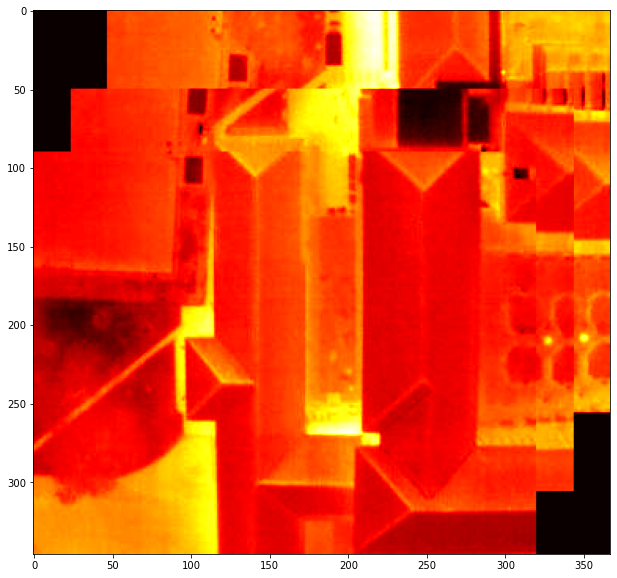

In [ ]:
start = 6
end = 10
step = 2
edge = 5
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

tempfiles = ['temp0.jpg','temp1.jpg']

arr = hf.img_to_arr(merged.iloc[start]['imgPath'], xq=xq, yq=yq)
imageio.imwrite(tempfiles[0],np.dstack((arr,arr,arr)))
result = imageio.imread(tempfiles[0])
coords = [idf.iloc[start]['xc'], idf.iloc[start]['yc']]
for imgNum in tqdm(np.arange(start+step if start < end else start-step,end+1,step if start < end else -step)):
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
    arr = hf.img_to_arr(merged.iloc[imgNum]['imgPath'], xq=xq, yq=yq)
    imageio.imwrite(tempfiles[1],np.dstack((arr,arr,arr)))
    # Read images - Make sure that the train image is the image that will be transformed
    trainImg, queryImg = result.astype(np.uint8), imageio.imread(tempfiles[1])

    #for i in tempfiles: os.remove(i)
    # Opencv defines the color channel in the order BGR - transform it to RGB to be compatible to matplotlib
    trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]

    # Detect the keypoints and features on both images
    kpsA, featuresA = hf.detectAndDescribe(trainImg_gray, method=feature_extractor)
    kpsB, featuresB = hf.detectAndDescribe(queryImg_gray, method=feature_extractor)

    if feature_matching == 'bf': matches = hf.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    elif feature_matching == 'knn': matches = hf.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)

    # Get key points from both images
    ma = np.array([kpsA[j].pt for j in [i.queryIdx for i in matches]])
    mb = np.array([kpsB[j].pt for j in [i.trainIdx for i in matches]])

    # Filter by only matches in direction of travel
    xmov, ymov = idf.iloc[imgNum]['xc']-coords[0], idf.iloc[imgNum]['yc']-coords[1]
    bothMov = 2
    if xmov < bothMov/2 and ymov < bothMov/2:
        mam, mbm = ma, mb
    else: 
        if abs(xmov) > abs(ymov):
            if xmov < 0:
                mam, mbm = ma[[ma[i,0]<mb[i,0] for i in range(len(ma))]], mb[[ma[i,0]<mb[i,0] for i in range(len(ma))]]
            else: mam, mbm = ma[[ma[i,0]>mb[i,0] for i in range(len(ma))]], mb[[ma[i,0]>mb[i,0] for i in range(len(ma))]]
        else:
            if ymov < 0:
                mam, mbm = ma[[ma[i,1]<mb[i,1] for i in range(len(ma))]], mb[[ma[i,1]<mb[i,1] for i in range(len(ma))]]
            else: mam, mbm = ma[[ma[i,1]>mb[i,1] for i in range(len(ma))]], mb[[ma[i,1]>mb[i,1] for i in range(len(ma))]]

    # Calculate new image by adding newly covered location to result (if matches are good enough)
    diff = np.round(np.median(mam-mbm, axis=0)).astype(int)
    if len(mam) > 10:# and np.std(mam-mbm, axis=0).mean() < 10:
        result = np.zeros([trainImg.shape[0]+abs(diff[1]),trainImg.shape[1]+abs(diff[0]),3]).astype(int)
        if diff[0] > 0:
            if diff[1] > 0:
                print('first')
                result[:-abs(diff[1]),:-abs(diff[0]),:] = trainImg
                result[-abs(diff[1]):,-queryImg.shape[1]:,:] = queryImg[0:abs(diff[1]):,:,:]
                result[-queryImg.shape[0]:, -abs(diff[0]):,:] = queryImg[:,-abs(diff[0]):,:]
            else:
                print('second')
                result[abs(diff[1]):,:-abs(diff[0]),:] = trainImg
                result[0:abs(diff[1]),-queryImg.shape[1]:,:] = queryImg[0:abs(diff[1]):,:,:]
                result[0:queryImg.shape[0], -abs(diff[0]):,:] = queryImg[:,-abs(diff[0]):,:]
        else:
            if diff[1] > 0:
                print('3rd')
                result[:-abs(diff[1]),abs(diff[0]):,:] = trainImg
                result[-abs(diff[1]):,0:queryImg.shape[1],:] = queryImg[0:abs(diff[1]),:,:]
                result[-queryImg.shape[0]:, 0:abs(diff[0]),:] = queryImg[:,0:abs(diff[0]),:]
            else:
                print('4th')
#                 result[abs(diff[1]):,abs(diff[0]):,:] = trainImg
#                 result[0:abs(diff[1]),0:queryImg.shape[1],:] = queryImg[0:abs(diff[1]),:,:]
#                 result[0:queryImg.shape[0], 0:abs(diff[0]),:] = queryImg[:,0:abs(diff[0]),:]
                result[abs(diff[1])*edge:,abs(diff[0])*edge:,:] = trainImg[abs(diff[1])*(edge-1):,abs(diff[0])*(edge-1):,:]
                result[0:abs(diff[1])*edge,0:queryImg.shape[1],:] = queryImg[0:abs(diff[1])*edge,:,:]
                result[0:queryImg.shape[0], 0:abs(diff[0])*edge,:] = queryImg[:,0:abs(diff[0])*edge,:]
        print('Image {} merged.'.format(str(imgNum)))
        coords += diff/2 
    else: print('Image {}, poor matching'.format(str(imgNum)))
    print(result.shape)

    
# show the cropped image
#for i in tempfiles: os.remove(i)
# image_to_write = cv2.cvtColor(result.astype(np.uint8), cv2.COLOR_RGB2BGR)
# comboImg = "plots/combo.jpg"
# cv2.imwrite(comboImg, image_to_write)
plt.figure(figsize=(20,10))
plt.imshow(result.mean(axis=2),cmap=cmap)